In [1]:
%pip install transformers tensorflow pandas numpy matplotlib seaborn scikit-learn

In [2]:
# =========================
# 0) 라이브러리 & 환경 설정
# =========================
import os, random, numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, TFBertForSequenceClassification

# 재현성 고정
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

print("환경 준비 완료")

환경 준비 완료


In [3]:
# pandas read_excel 함수 사용을 위한 openpyxl 설치
%pip install openpyxl -q

In [20]:
# =========================
# 1) 하이퍼파라미터 & 경로
# =========================
BERT_MODEL_NAME = "bert-base-multilingual-cased"
MAX_LENGTH      = 128
BATCH_SIZE      = 16
EPOCHS          = 5
LEARNING_RATE   = 2e-5

TRAIN_DATA_URL = 'https://github.com/gzone2000/TEMP_TEST/raw/master/A_comment_train.xlsx'
TEST_DATA_URL  = 'https://github.com/gzone2000/TEMP_TEST/raw/master/A_comment_test.xlsx'

print("설정 완료")


설정 완료


In [9]:
# =========================
# 2) 데이터 로드 (DataFrame 계층: train_df / test_df)
# =========================
train_df = pd.read_excel(TRAIN_DATA_URL, engine='openpyxl')
test_df  = pd.read_excel(TEST_DATA_URL,  engine='openpyxl')

print(f"훈련 데이터 크기: {train_df.shape}")
print(f"테스트 데이터 크기: {test_df.shape}")

훈련 데이터 크기: (251, 3)
테스트 데이터 크기: (101, 3)


In [10]:
train_df

,Unnamed: 0,data,label
0,0,재미는 있는데 시간이 짧은게 아쉽네요~,긍정
1,1,"OO 관련 내용은 우리 직원과는 거리가 멀었음, 특히, 사내에 홍보할 내용은 아니라고 봄",부정
2,2,스토리가 너무 딱딱해서 별로였음,부정
3,3,프로그램A 화이팅하세요!!,긍정
4,4,높은 곳에 올라가는 모습이 너무 위험해 보여요.,부정
...,...,...,...
246,246,영상F서비스로 간편하게 설치!좋아요\n우리 회사화이팅!,긍정
247,247,모든 업무에서 맡은바 업무에 서 최선을 다하는 모습이 좋습니다! 화이팅 입니다.,긍정
248,248,"사내방송 특성상 최근 이슈화 되거나, 언급이 자주되는 '키워드'를 중심으로 뉴스를 ...",부정
249,249,방송 시간이 너무 길어요.,부정


In [11]:
test_df

,Unnamed: 0,data,label
0,0,유익한 정보 감사합니다. 취미로 바다에 자주 나가는 편인데 이런 기술이 있는지 몰랐네요.,긍정
1,1,발빠른 영입 수고 했네요 고객들이 좋아합니다.,긍정
2,2,프로그램C 주제가 우리의 기술력이 바탕이 된다는점~~..항상 응원합니다,긍정
3,3,언제나 밝은 미소로 열심히 근무하시는 청원 경찰 분들께 감사드립니다. 항상 건강하시...,긍정
4,4,안전사고에 대한 개념도 함께 소개 되었으면 더 완벽했을 것 같네요,부정
...,...,...,...
96,96,작년에 프로그램A를 재밋게 봤던 시청자로서 올해의 미니드라마도 매우 기대가 됩니다....,긍정
97,97,프로그램C 잘 보았습니다. 모든일의 바탕은 안전인것 같습니다. 모두를 보호하는 최고...,긍정
98,98,위험한 시설에 대한 설명도 부탁드립니다,부정
99,99,구체적으로 어떤 활동을 해왔었고 앞으로 어떤활동을 할건지 잘 설명해줬으면 좋았을 것...,부정


In [12]:
train_df['label'].value_counts()

,count
label,
긍정,126
부정,125


In [13]:
test_df['label'].value_counts()

,count
label,
긍정,59
부정,42


In [ ]:

# 필수 컬럼 확인
#for name, df in [("train_df", train_df), ("test_df", test_df)]:
#    assert {"data","label"} <= set(df.columns), f"{name}에 'data'/'label' 컬럼이 필요합니다."

# 라벨 문자열 정리(공백/대소문자)
#train_df["label"] = train_df["label"].astype(str).str.strip().str.casefold()
#test_df["label"]  = test_df["label"].astype(str).str.strip().str.casefold()

# 라벨 값 검증 (부정/긍정 두 클래스 전제)
#assert set(train_df["label"].unique()) <= {"부정","긍정"}, f"train_df 라벨 값 점검 필요: {train_df['label'].unique()}"
#assert set(test_df["label"].unique())  <= {"부정","긍정"}, f"test_df 라벨 값 점검 필요:  {test_df['label'].unique()}"


In [14]:

# LabelEncoder로 정수 변환 (사전순: 부정=0, 긍정=1)
le = LabelEncoder()
train_df["label_id"] = le.fit_transform(train_df["label"])
test_df["label_id"]  = le.transform(test_df["label"])

id2label = {i: lbl for i, lbl in enumerate(le.classes_)}  # {0:'부정', 1:'긍정'}
label2id = {v: k for k, v in id2label.items()}
NUM_LABELS = len(id2label)

print("라벨 매핑(label→id):", label2id)
display(train_df.head())
display(test_df.head())

라벨 매핑(label→id): {'긍정': 0, '부정': 1}


,Unnamed: 0,data,label,label_id
0,0,재미는 있는데 시간이 짧은게 아쉽네요~,긍정,0
1,1,"OO 관련 내용은 우리 직원과는 거리가 멀었음, 특히, 사내에 홍보할 내용은 아니라고 봄",부정,1
2,2,스토리가 너무 딱딱해서 별로였음,부정,1
3,3,프로그램A 화이팅하세요!!,긍정,0
4,4,높은 곳에 올라가는 모습이 너무 위험해 보여요.,부정,1


,Unnamed: 0,data,label,label_id
0,0,유익한 정보 감사합니다. 취미로 바다에 자주 나가는 편인데 이런 기술이 있는지 몰랐네요.,긍정,0
1,1,발빠른 영입 수고 했네요 고객들이 좋아합니다.,긍정,0
2,2,프로그램C 주제가 우리의 기술력이 바탕이 된다는점~~..항상 응원합니다,긍정,0
3,3,언제나 밝은 미소로 열심히 근무하시는 청원 경찰 분들께 감사드립니다. 항상 건강하시...,긍정,0
4,4,안전사고에 대한 개념도 함께 소개 되었으면 더 완벽했을 것 같네요,부정,1


In [15]:
# =========================
# 3) 훈련/검증 분리 (DataFrame → train_texts/valid_texts + y_train/y_valid)
# =========================
train_texts, valid_texts, y_train, y_valid = train_test_split(
    train_df["data"].tolist(),
    train_df["label_id"].values,
    test_size=0.2,
    random_state=SEED,
    stratify=train_df["label_id"].values
)

X_test  = test_df["data"].tolist()
y_test  = test_df["label_id"].values  # ★ 최종 평가용 (학습/검증에 사용 금지)

print(f"훈련 샘플: {len(train_texts)} | 검증 샘플: {len(valid_texts)} | 테스트 샘플: {len(X_test)}")


훈련 샘플: 200 | 검증 샘플: 51 | 테스트 샘플: 101


In [16]:
# =========================
# 4) 토크나이징 (Tokenizer 계층)
# =========================
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)

train_enc = tokenizer(train_texts, truncation=True, padding="max_length",
                      max_length=MAX_LENGTH, return_tensors="tf")
valid_enc = tokenizer(valid_texts, truncation=True, padding="max_length",
                      max_length=MAX_LENGTH, return_tensors="tf")
test_enc  = tokenizer(X_test,      truncation=True, padding="max_length",
                      max_length=MAX_LENGTH, return_tensors="tf")

print("토크나이징 완료")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


토크나이징 완료


In [17]:
# =========================
# 5) TensorFlow Dataset 계층 (train_ds / valid_ds / test_ds)
# =========================
train_ds = tf.data.Dataset.from_tensor_slices(
    ({k: v for k, v in train_enc.items()}, y_train)
).shuffle(buffer_size=len(train_texts), seed=SEED).batch(BATCH_SIZE)

valid_ds = tf.data.Dataset.from_tensor_slices(
    ({k: v for k, v in valid_enc.items()}, y_valid)
).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices(
    ({k: v for k, v in test_enc.items()}, y_test)
).batch(BATCH_SIZE)

print("데이터셋 준비 완료")

# 데이터 누설 방지 안전장치
assert isinstance(train_ds, tf.data.Dataset) and isinstance(valid_ds, tf.data.Dataset)
assert isinstance(test_ds, tf.data.Dataset)
# ★ 테스트셋은 학습에 쓰지 않는다!


데이터셋 준비 완료


In [18]:
# =========================
# 6) 모델 생성 & 컴파일 (모델 계층)
# =========================
print("BERT 분류 모델 초기화 중...")
model = TFBertForSequenceClassification.from_pretrained(
    BERT_MODEL_NAME,
    num_labels=NUM_LABELS,  # 2
    id2label=id2label,
    label2id=label2id,
    from_pt=True
)
print("BERT 모델 로드 완료")

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss      = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics   = ['accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
print("모델 컴파일 완료")


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


BERT 분류 모델 초기화 중...


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT 모델 로드 완료
모델 컴파일 완료


In [21]:
# =========================
# 7) 학습 (fit: train_ds + valid_ds)
# =========================
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', mode='max', patience=2, restore_best_weights=True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=1, min_lr=1e-7, verbose=1
)

print("학습 시작...")
history = model.fit(
    train_ds,
    validation_data=valid_ds,   # ← 검증 전용
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)
print("학습 종료")


학습 시작...
Epoch 1/5
13/13 [==============================] - 7s 549ms/step - loss: 0.0950 - accuracy: 0.9700 - val_loss: 0.4522 - val_accuracy: 0.8431 - lr: 1.0000e-05
Epoch 2/5
13/13 [==============================] - ETA: 0s - loss: 0.0690 - accuracy: 0.9800
Epoch 2: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
13/13 [==============================] - 6s 501ms/step - loss: 0.0690 - accuracy: 0.9800 - val_loss: 0.5761 - val_accuracy: 0.8431 - lr: 1.0000e-05
Epoch 3/5
13/13 [==============================] - ETA: 0s - loss: 0.0317 - accuracy: 0.9950
Epoch 3: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
13/13 [==============================] - 6s 467ms/step - loss: 0.0317 - accuracy: 0.9950 - val_loss: 0.5139 - val_accuracy: 0.8431 - lr: 5.0000e-06
학습 종료



[검증셋] 예측/평가 중...
[검증] 정확도: 0.8431 | macro-F1: 0.8431 | ROC-AUC: 0.9062

분류 보고서(검증):
              precision    recall  f1-score   support

          긍정       0.85      0.85      0.85        26
          부정       0.84      0.84      0.84        25

    accuracy                           0.84        51
   macro avg       0.84      0.84      0.84        51
weighted avg       0.84      0.84      0.84        51



/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44557 (\N{HANGUL SYLLABLE GEUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/tmp/ipython-input-4144946604.py:32: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/tmp/ipython-input-4144946604.py:32: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/tmp/ipython-input-4144946604.py:32: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/tmp/ipython-input-4144946604.py:32

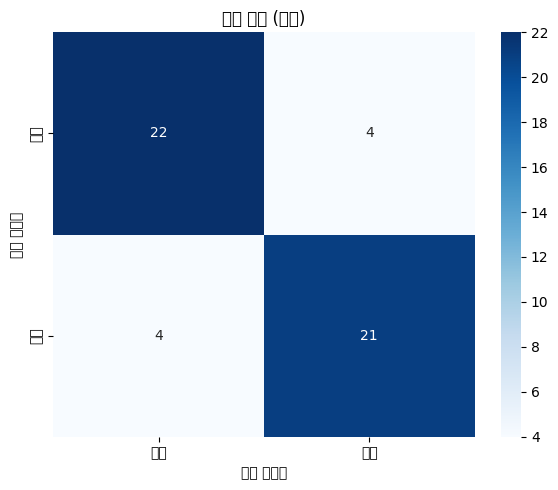

In [22]:
# =========================
# 8) 검증셋 평가 (valid_ds)
# =========================
print("\n[검증셋] 예측/평가 중...")
pred_valid = model.predict(valid_ds, verbose=0)
logits_v = getattr(pred_valid, "logits", pred_valid[0] if isinstance(pred_valid, (list, tuple)) else pred_valid)

probs_v = tf.nn.softmax(logits_v, axis=1).numpy()
y_pred_v = probs_v.argmax(axis=1)
p_pos_v  = probs_v[:, 1]

assert len(y_pred_v) == len(y_valid), "검증 예측/정답 개수 불일치"

acc_v      = accuracy_score(y_valid, y_pred_v)
macro_f1_v = f1_score(y_valid, y_pred_v, average='macro')
try:
    auc_v = roc_auc_score(y_valid, p_pos_v)
except Exception:
    auc_v = np.nan

print(f"[검증] 정확도: {acc_v:.4f} | macro-F1: {macro_f1_v:.4f} | ROC-AUC: {auc_v:.4f}")
print("\n분류 보고서(검증):")
print(classification_report(y_valid, y_pred_v, target_names=[id2label[0], id2label[1]]))

cm_v = confusion_matrix(y_valid, y_pred_v, labels=[0,1])
plt.figure(figsize=(6,5))
sns.heatmap(cm_v, annot=True, fmt='d', cmap='Blues',
            xticklabels=[id2label[0], id2label[1]],
            yticklabels=[id2label[0], id2label[1]])
plt.title('혼동 행렬 (검증)')
plt.xlabel('예측 레이블'); plt.ylabel('실제 레이블')
plt.tight_layout(); plt.show()



[최종 테스트셋] 예측/평가 중...
[테스트] 정확도: 0.8218 | macro-F1: 0.8120 | ROC-AUC: 0.8971

분류 보고서(테스트):
              precision    recall  f1-score   support

          긍정       0.82      0.90      0.85        59
          부정       0.83      0.71      0.77        42

    accuracy                           0.82       101
   macro avg       0.82      0.81      0.81       101
weighted avg       0.82      0.82      0.82       101



/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44557 (\N{HANGUL SYLLABLE GEUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/tmp/ipython-input-3690564481.py:32: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/tmp/ipython-input-3690564481.py:32: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/tmp/ipython-input-3690564481.py:32: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/tmp/ipython-input-3690564481.py:32

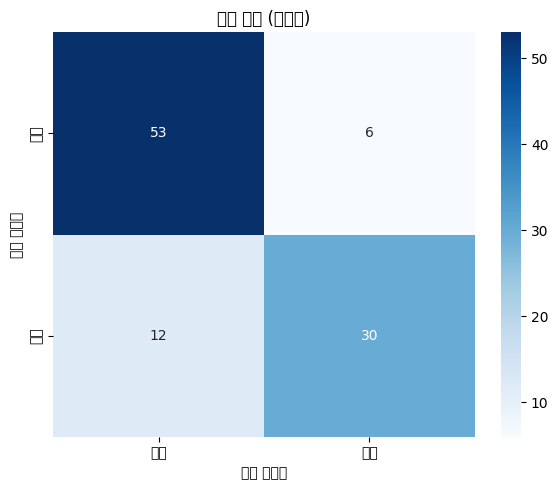

In [23]:
# =========================
# 9) 최종 테스트셋 평가 (test_ds) — 학습에 절대 사용 X
# =========================
print("\n[최종 테스트셋] 예측/평가 중...")
pred_test = model.predict(test_ds, verbose=0)
logits_t = getattr(pred_test, "logits", pred_test[0] if isinstance(pred_test, (list, tuple)) else pred_test)

probs_t = tf.nn.softmax(logits_t, axis=1).numpy()
y_pred_t = probs_t.argmax(axis=1)
p_pos_t  = probs_t[:, 1]

assert len(y_pred_t) == len(y_test), "테스트 예측/정답 개수 불일치"

acc_t      = accuracy_score(y_test, y_pred_t)
macro_f1_t = f1_score(y_test, y_pred_t, average='macro')
try:
    auc_t = roc_auc_score(y_test, p_pos_t)
except Exception:
    auc_t = np.nan

print(f"[테스트] 정확도: {acc_t:.4f} | macro-F1: {macro_f1_t:.4f} | ROC-AUC: {auc_t:.4f}")
print("\n분류 보고서(테스트):")
print(classification_report(y_test, y_pred_t, target_names=[id2label[0], id2label[1]]))

cm_t = confusion_matrix(y_test, y_pred_t, labels=[0,1])
plt.figure(figsize=(6,5))
sns.heatmap(cm_t, annot=True, fmt='d', cmap='Blues',
            xticklabels=[id2label[0], id2label[1]],
            yticklabels=[id2label[0], id2label[1]])
plt.title('혼동 행렬 (테스트)')
plt.xlabel('예측 레이블'); plt.ylabel('실제 레이블')
plt.tight_layout(); plt.show()


In [24]:
# =========================
# 10) 테스트 결과 저장 (선택)
# =========================
results = pd.DataFrame({
    "텍스트": X_test,
    "실제 레이블": [id2label[i] for i in y_test],
    "예측 레이블": [id2label[i] for i in y_pred_t],
    "부정 확률": probs_t[:, 0],
    "긍정 확률": probs_t[:, 1],
    "예측 신뢰도": probs_t.max(axis=1),
})
display(results.head())

out_path = "./pred_results_test.csv"
results.to_csv(out_path, index=False, encoding="utf-8-sig")
print(f"테스트 예측 결과 저장: {out_path}")


,텍스트,실제 레이블,예측 레이블,부정 확률,긍정 확률,예측 신뢰도
0,유익한 정보 감사합니다. 취미로 바다에 자주 나가는 편인데 이런 기술이 있는지 몰랐네요.,긍정,긍정,0.914063,0.085937,0.914063
1,발빠른 영입 수고 했네요 고객들이 좋아합니다.,긍정,긍정,0.977087,0.022913,0.977087
2,프로그램C 주제가 우리의 기술력이 바탕이 된다는점~~..항상 응원합니다,긍정,긍정,0.984683,0.015317,0.984683
3,언제나 밝은 미소로 열심히 근무하시는 청원 경찰 분들께 감사드립니다. 항상 건강하시...,긍정,긍정,0.981340,0.018660,0.981340
4,안전사고에 대한 개념도 함께 소개 되었으면 더 완벽했을 것 같네요,부정,부정,0.028034,0.971966,0.971966


테스트 예측 결과 저장: ./pred_results_test.csv


In [26]:
model.save_pretrained("./bert_model")